In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("data.csv")
data = data[data['species_name'] == "Aceros waldeni (Visayan Writhed Hornbill)"]
data=data[['date_report','no_observation']]
data.head()

,date_report,no_observation
1,2016-01-11,17
2,2016-01-12,10
3,2016-01-18,17
5,2016-01-12,12
9,2016-02-15,12


In [3]:
data.index = pd.to_datetime(data['date_report'])
data.drop(columns='date_report',inplace=True)
data.head()
data = data.resample('M').sum()
data

,no_observation
date_report,
2016-01-31,56
2016-02-29,41
2016-03-31,41
2016-04-30,45
2016-05-31,39
...,...
2021-08-31,58
2021-09-30,73
2021-10-31,29


In [4]:
data.isna().sum()

no_observation    0
dtype: int64

<AxesSubplot:xlabel='date_report'>

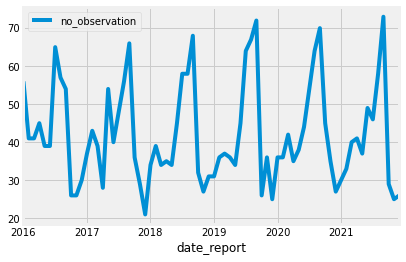

In [5]:
data.plot()

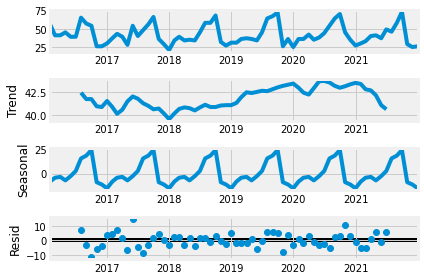

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_data = seasonal_decompose(data, model="additive")
decompose_data.plot();

<AxesSubplot:xlabel='date_report'>

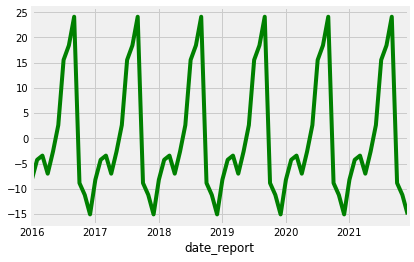

In [7]:
seasonality=decompose_data.seasonal
seasonality.plot(color='green')

In [8]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(data.no_observation, autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -2.187836473394911
2. P-Value :  0.2106896970953071
3. Num Of Lags :  11
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 60
5. Critical Values :
	 1% :  -3.5443688564814813
	 5% :  -2.9110731481481484
	 10% :  -2.5931902777777776


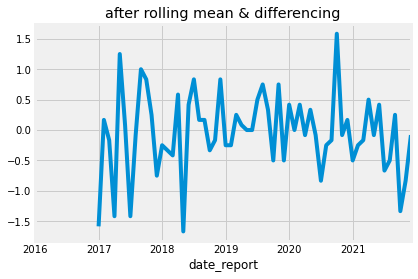

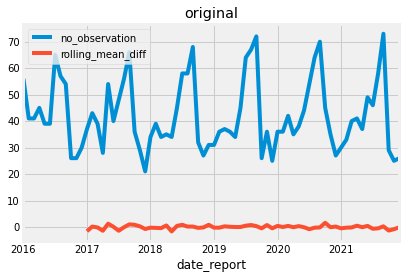

In [9]:
rolling_mean = data.rolling(window = 12).mean()
data['rolling_mean_diff'] = rolling_mean - rolling_mean.shift()
ax1 = plt.subplot()
data['rolling_mean_diff'].plot(title='after rolling mean & differencing');
ax2 = plt.subplot()
data.plot(title='original');

In [10]:
dftest = adfuller(data['rolling_mean_diff'].dropna(), autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
  print("\t",key, ": ", val)

1. ADF :  -8.681935135372791
2. P-Value :  4.262857673055344e-14
3. Num Of Lags :  0
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 59
5. Critical Values :
	 1% :  -3.5463945337644063
	 5% :  -2.911939409384601
	 10% :  -2.5936515282964665


In [11]:
from pmdarima import auto_arima

Sarimax_model = auto_arima(data.no_observation,
                       start_p=0,
                       start_q=0,
                       max_p=3,
                       max_q=3,
                       m=12,
                       test='adf',
                       seasonal=True,
                       d=1,
                       D=1,
                       trace=True,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True)

Sarimax_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=437.355, Time=0.50 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=456.696, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=433.507, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=410.663, Time=0.35 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=inf, Time=0.12 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.62 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=412.325, Time=0.60 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=413.390, Time=0.15 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.58 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=437.220, Time=0.23 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=412.643, Time=0.28 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=412.635, Time=0.64 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=428.296, Time=0.35 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=inf, Time=0.65 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=412.45

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   72
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -202.332
Date:                            Sun, 28 Nov 2021   AIC                            410.663
Time:                                    11:12:02   BIC                            416.896
Sample:                                         0   HQIC                           413.096
                                             - 72                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9233      0.114     -8.100      0.000      -1.147      -0.700
ma.S.L12      -0.5809      0.214     -2.720      0.007      -0.999      -0.162
sigma2        49.2439     11.797      4.174      0.000      26.122      72.366
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                 0.72
Prob(Q):                              0.71   Prob(JB):                         0.70
Heteroskedasticity (H):               0.46   Skew:                             0.21
Prob(H) (two-sided):                  0.09   Kurtosis:                         2.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [12]:
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings("ignore")

model=ARIMA(data['no_observation'],order=(0,1,1))
history=model.fit()

In [13]:
history.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:       D.no_observation   No. Observations:                   71
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -284.585
Method:                       css-mle   S.D. of innovations             13.318
Date:                Sun, 28 Nov 2021   AIC                            575.170
Time:                        11:12:02   BIC                            581.958
Sample:                    02-29-2016   HQIC                           577.870
                         - 12-31-2021                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.3922      1.350     -0.291      0.771      -3.038       2.253
ma.L1.D.no_observation    -0.1484      0.142     -1.047      0.295      -0.426       0.129
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            6.7369           +0.0000j            6.7369            0.0000
-----------------------------------------------------------------------------
"""

<AxesSubplot:xlabel='date_report'>

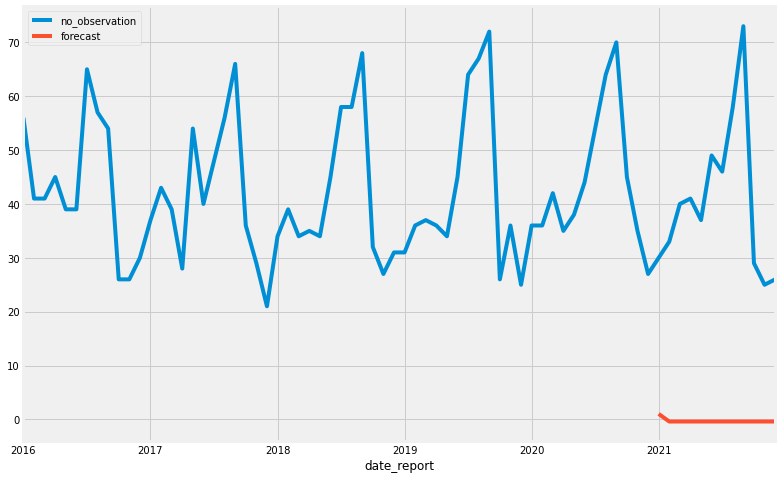

In [14]:
model_fit=model.fit()
data['forecast']=model_fit.predict(start=60,end=72,dynamic=True)
data[['no_observation','forecast']].plot(figsize=(12,8))

In [15]:
model=ARIMA(data['rolling_mean_diff'].dropna(),order=(0,1,1))
model_fit=model.fit()

<AxesSubplot:xlabel='date_report'>

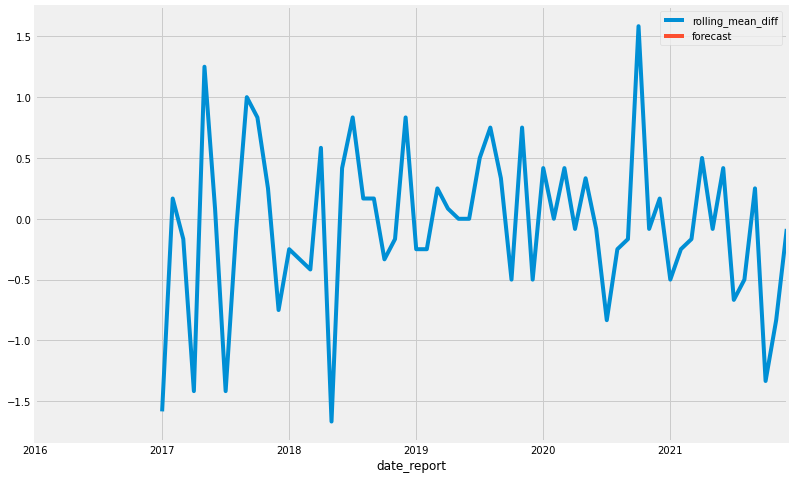

In [16]:
data['forecast']=model_fit.predict(start=60,end=72,dynamic=True)
data[['rolling_mean_diff','forecast']].plot(figsize=(12,8))

In [17]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(data['no_observation'],order=(0, 1, 1),seasonal_order=(0,1,1,12))
results=model.fit()

<AxesSubplot:xlabel='date_report'>

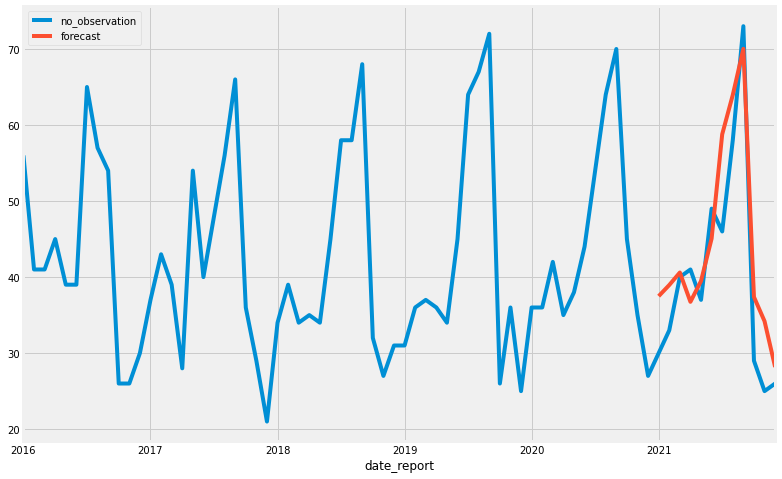

In [18]:
data['forecast']=results.predict(start=60,end=72,dynamic=True)
data[['no_observation','forecast']].plot(figsize=(12,8))

In [19]:
s_residuals = data['no_observation'] -data['forecast']

In [20]:
print('Mean Absolute Percent Error:', round(np.mean(abs(s_residuals/data.no_observation)),2))

Mean Absolute Percent Error: 0.15


In [21]:
print('Root Mean Squared Error:', np.sqrt(np.mean(s_residuals**2)))

Root Mean Squared Error: 6.447502246691986


In [22]:
from pandas.tseries.offsets import DateOffset
pred_date=[data.index[-1]+ DateOffset(months=x)for x in range(0,24)]

In [23]:
pred_date=pd.DataFrame(index=pred_date[1:],columns=data.columns)
pred_date

,no_observation,rolling_mean_diff,forecast
2022-01-31,NaN,NaN,NaN
2022-02-28,NaN,NaN,NaN
2022-03-31,NaN,NaN,NaN
2022-04-30,NaN,NaN,NaN
2022-05-31,NaN,NaN,NaN
2022-06-30,NaN,NaN,NaN
2022-07-31,NaN,NaN,NaN
2022-08-31,NaN,NaN,NaN
2022-09-30,NaN,NaN,NaN
2022-10-31,NaN,NaN,NaN


In [24]:
data=pd.concat([data,pred_date])

,no_observation,rolling_mean_diff,forecast
2016-01-31,56,NaN,NaN
2016-02-29,41,NaN,NaN
2016-03-31,41,NaN,NaN
2016-04-30,45,NaN,NaN
2016-05-31,39,NaN,NaN
...,...,...,...
2023-07-31,NaN,NaN,50.973555
2023-08-31,NaN,NaN,59.020279
2023-09-30,NaN,NaN,68.847162
2023-10-31,NaN,NaN,31.429132


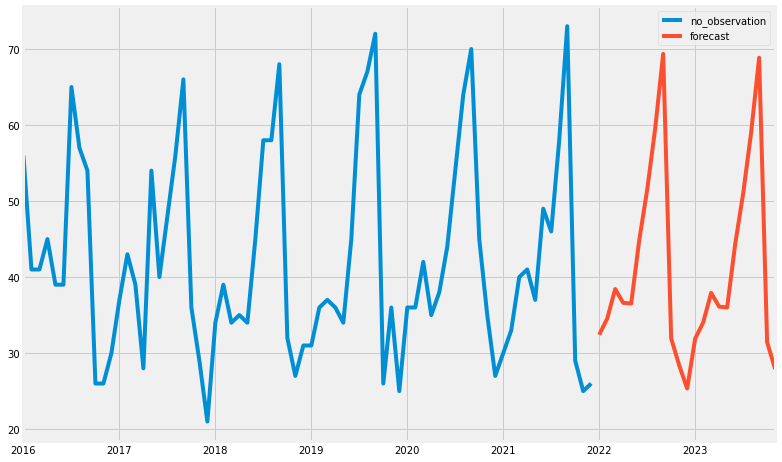

In [25]:
data['forecast'] = results.predict(start = 72, end = 96, dynamic= True)  
data[['no_observation', 'forecast']].plot(figsize=(12, 8))
data

In [26]:
data.tail(24)

,no_observation,rolling_mean_diff,forecast
2021-12-31,26,-0.083333,NaN
2022-01-31,NaN,NaN,32.420263
2022-02-28,NaN,NaN,34.529859
2022-03-31,NaN,NaN,38.426998
2022-04-30,NaN,NaN,36.617972
2022-05-31,NaN,NaN,36.517180
2022-06-30,NaN,NaN,44.798080
2022-07-31,NaN,NaN,51.481721
2022-08-31,NaN,NaN,59.528445
2022-09-30,NaN,NaN,69.355328
